# PBjam 2.0 tutorial

PBjam is meant to perform (semi) automated peakbagging of solar-like oscillators. The idea being that it should be relatively easy and painless to get mode frequencies of stars with a precision that is suitable for stellar modeling. Let's see if we've succeeded...

The code can be roughly divided into two main sections, the mode identification stage and the detailed peakbagging stage. The mode ID stage fits a model consisting of a known set of radial orders and angular degrees to the spectrum, so that if a peak is found in the spectrum and the model labels it l=0 for example, then roughly $\Delta \nu$ further along the spectrum we should expect to see another l=0 mode. If we don't then we need to vary the parameters of the model, by for example increasing $\Delta \nu$.

This is all done in a Bayesian framework, so we have a prior and we sample the posterior distribution which is the product of the prior and the likelihood of the data given the model. This prior is built from thousands of previous measurements of the model parameters of other stars, so that if we provide an initial estimate of $\Delta \nu$ and $\nu_{\mathrm{max}}$ for example, then PBjam knows what range of other mode parameters are important, and crucially also any correlation there might be between them. Of course this all hinges on the solar-like oscillators having a predictable pattern of modes, where it's just the scale of the pattern that remains the unknown quantity ($\Delta \nu$, $\nu_{\mathrm{max}}$ etc.), and so naturally the models in PBjam wouldn't work on other types of oscillators.

Once a rough pattern is established in the mode ID stage, the mode parameters are passed to the detailed peakbagging stage, where the model is relaxed considerably such that the mode frequencies for example are all left as free parameters. This allows PBjam to capture more detailed structure in the spectrum, which could occur due, for example, to acoustic glitches, or simply to correct for inaccuracies in the mode ID model.

You can read more about the idea behind PBjam in Nielsen et al. (2021). However, we are currently in the process of preparing for another release of the code, and we're therefore still also writing up the paper on these updates. For now this tutorial will get you running and using the basic parts of the code. There is still a lot of work to do in terms of polishing different aspects of the code, so feedback is welcome!

# 1. Using the modeID class to identify modes
We can start with setting the target name and loading the data. If you have already downloaded the data you can just load it using your favorite method. I tend to use numpy as shown below.

In [1]:
tgt = 'KIC5184732'

# If you have already downloaded the data you can just load it here
import numpy as np
f, s = np.genfromtxt(f'{tgt}.pow').T

Otherwise you can use the wrapper built into PBjam. In essence this module just wraps the various `Lightkurve` steps to getting a time series but also includes a method for computing the PSD . 

**Note:** The IO.psd class normalizes the PSD consistently (Parseval). If you are using a custom PSD, be sure it is Parseval normalized, otherwise the built-in prior on mode heights won't be very helpful. The easiest way to do this is to start with the custom time series and use the IO.psd class to compute the psd, otherwise you will have to normalize the spectrum so the integral of power is equivalent to variance in the light curve.

In [2]:
from pbjam import IO

psd = IO.psd(tgt, lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'}, use_cached=True)
 
psd()

f = psd.freq

s = psd.powerdensity

/home/ADF/nielsemb/.local/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/ADF/nielsemb/.lightkurve/cache. Please move all the files in the legacy directory /home/ADF/nielsemb/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Using cached search result.
Loading fits files from cache.


For targets with very long time series, and high SNR of the oscillations, it's usually not necessary to use the spectrum at full resolution. The mode ID process just takes longer. So below we've reduced the resolution by a factor of 10, which is still enough to get a good estimate of the background and also the mode ID. 

If you are using a shorter time series, adjust the downsampling factor accordingly. Just be sure you can still make out the modes in the spectrum.

Text(0.5, 0, 'Frequency [$\\mu$Hz]')

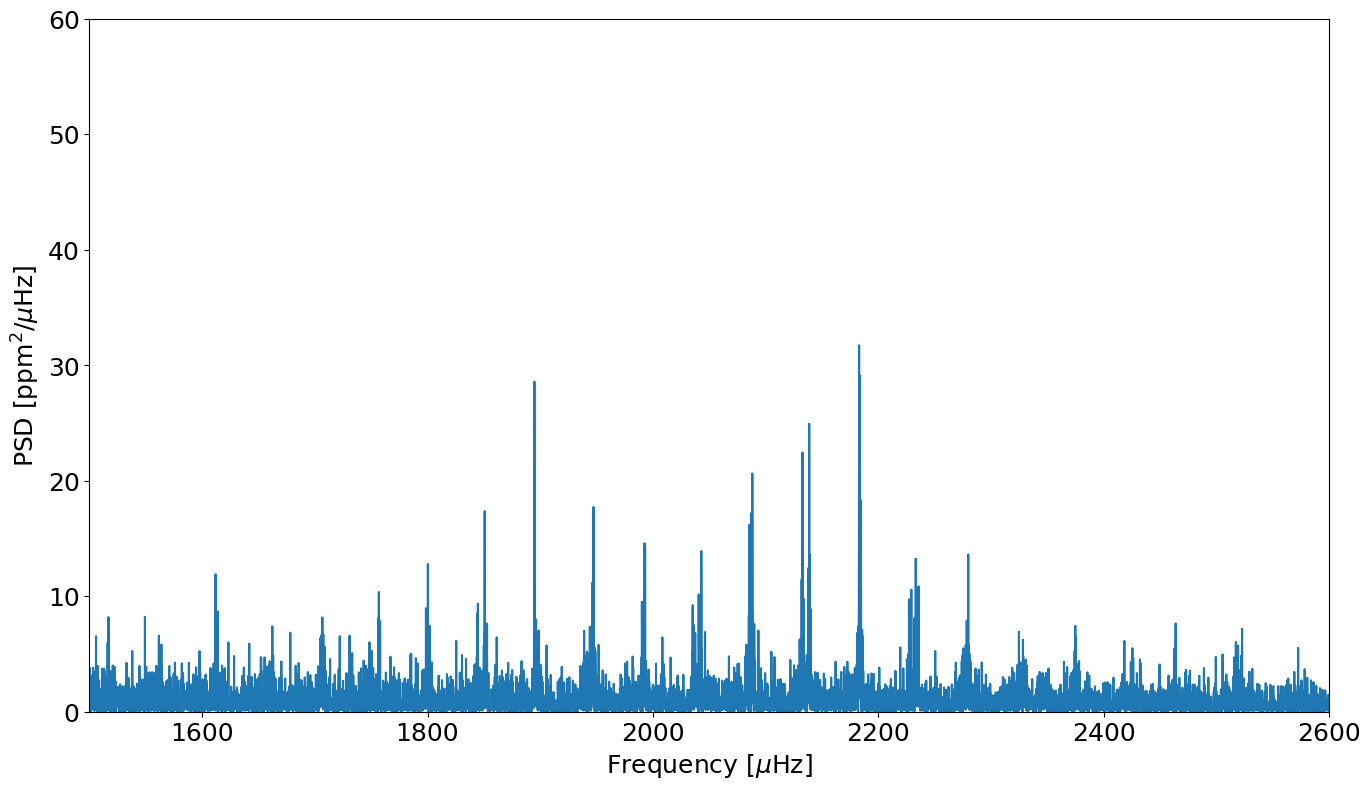

In [3]:
downsampling = 10

f = f[::downsampling]

s = s[::downsampling]

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(f,s)
ax.set_xlim(1500, 2600)
ax.set_ylim(0, 60)
ax.set_ylabel('PSD [ppm$^2/\mu$Hz]')
ax.set_xlabel('Frequency [$\mu$Hz]')

## Observational parameters
As with the previous version of PBjam we supply some basic initial parameters to guide the mode ID process. These are $T_{\mathrm{eff}}$, Gaia $G_{\mathrm{bp}}-G_{\mathrm{rp}}$ color index, an estimate of $\nu_{\mathrm{max}}$ and $\Delta \nu$. You need to look up these parameters for the target you've chosen. 

Simbad is very helpful for looking up the $G_{\mathrm{bp}}-G_{\mathrm{rp}}$ color information, you can use either the GDR2 or GDR3 values here. Don't worry about being super precise

Each bit of information is added to a dictionary, where each entry consists of a list-like entry (tuples or arrays are also fine) which contain the mean and error of the relevant parameter.

In [4]:
addObs = {'teff' : (5846, 80), # K
          'bp_rp': (0.819174, 0.05),
          'numax': (2089.3, 20.0), # muHz
          'dnu'  : (95.545, 0.5)} # muHz

## Priors
With the update to PBjam we now apply a PCA-based dimensionality reduction method to the sample of prior observations for each of the model parameters. This means that the priors are constructed in a lower-dimensional latent space, instead of the full model space. We then compute 1D KDEs of the latent parameter distributions, which are then used in the sampling.

This relies on the sample of prior observations being fairly dense in the parameter space around the target star. Due to the increased model complexity ($\ell=1$ modes for example) PBjam doesn't currently have complete coverage of all parameters in all parts of parameter space. We therefore added an option to include manually specified priors for some of the parameters, in which case they are no longer included in constructing the latent space priors. An example of how to do this is shown at the end of this tutorial. For now let's get going with the mode ID.

## Initializing the mode ID sampler
The mode identification in PBjam 2.0 is done in two main steps:

1. We first identifies the $\ell=2,0$ modes by sampling a simple model of asymptotic p-modes. We also include a background model at this stage.

2. We then divide the PSD by this model to obtain a residual SNR spectrum which mostly just contains $\ell=1$ modes. We then apply a choice of three different models to this residual to find the $\ell=1$ modes. 

Let's start by initializing the mode ID and running the $\ell=2,0$ model. The mode ID class takes the frequency and spectrum arrays we defined above, as well as the dictionary of observational parameters. 

As in the first version of PBjam the choice of the number of radial p-mode orders, $N_p$, is left to the user. Including an excessive amount of orders will probably not improve the result since we rely on the 2nd order asymptotic relation for p-modes. This is only reliable within a few orders of $\nu_{\mathrm{max}}$ anyway, and so a suitable number for most stars is between 5-10.

Lastly we also specify the frequency range on which the model is constructed. If you're interested in the background parameters this should specify suitable limits, say from $10\mu$ Hz to the Nyquist frequency. PBjam will otherwise assume you just want a model that covers a small range around the $\nu_{\mathrm{max}}$ you've provided. 

In [5]:
from pbjam.modeID import modeID

N_p = 9
 
M = modeID(f, s, addObs, N_p=N_p)

### l=2,0 mode ID
With the class initialized we can run the $\ell=2,0$ model. For those who have used PBjam 1.0 this stage should be fairly familiar, however here we are using `Dynesty` to do the sampling instead of `emcee`. 

In [6]:
M.runl20model();

14531it [01:53, 128.12it/s, +600 | bound: 146 | nc: 1 | ncall: 420492 | eff(%):  3.604 | loglstar:   -inf < -8573.947 <    inf | logz: -8597.826 +/-  0.209 | dlogz:  0.001 >  0.609]


## Viewing and extracting the result
You can visualize the result by using the built-in spectrum plotting function. Running the `spectrum` method at this stage should produce a set of plots consisting of the full-spectrum view, a plot of models drawn from the posterior distribution, and at the bottom the residual after dividing out the l=2,0 model. This should only contain l=1 modes (and maybe some low amplitude l=3 modes), and is what is used in the next mode ID step.

(<Figure size 1600x1800 with 3 Axes>,
 array([<Axes: ylabel='PSD [$\\mathrm{ppm}^2/\\mu \\rm Hz$]'>,
        <Axes: ylabel='PSD [$\\mathrm{ppm}^2/\\mu \\rm Hz$]'>,
        <Axes: xlabel='Frequency ($\\mu \\rm Hz$)', ylabel='PSD [$\\mathrm{ppm}^2/\\mu \\rm Hz$]'>],
       dtype=object))

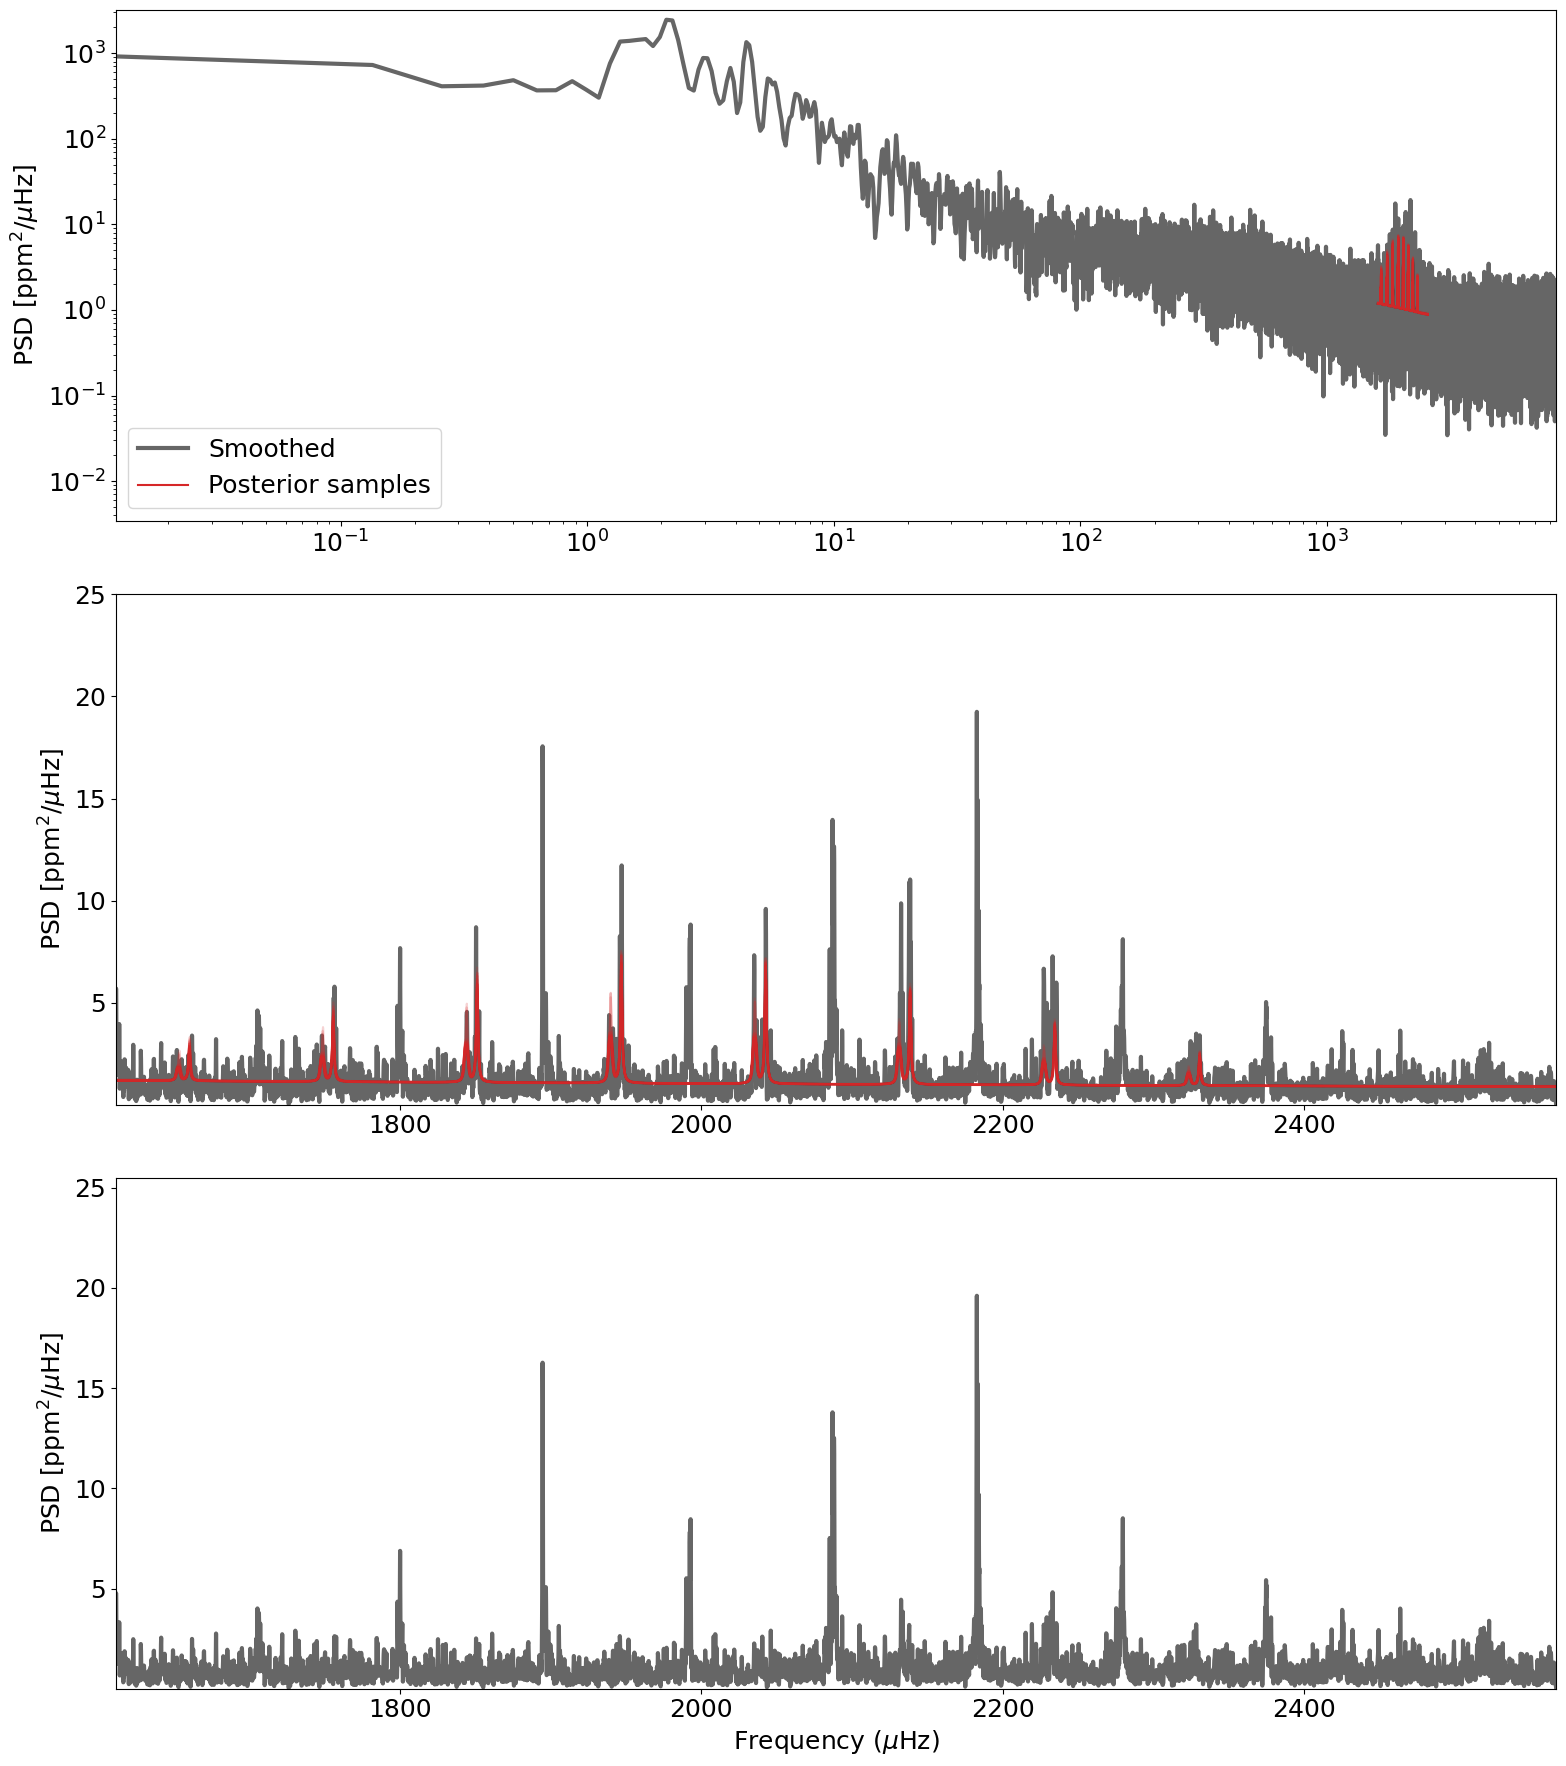

In [7]:
M.spectrum()

After running the l20model the model class instance will be updated to contain a `samples` attribute, which are the likelihood-weighted samples from the nested sampling process. Note that these are samples drawn from the prior that is defined in the latent space, this means that they don't necessarily correspond to any physical parameters. 

The mode ID class instance will also be updated to contain the results in a form that is a bit more human readable. These are contained in the `result` attribute, which is just a big dictionary of summary statistics and samples of the model parameters. The parameters have all been converted to linear scale.

In [8]:
M.result

{'ell': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2.,
        2.]),
 'enn': array([15., 16., 17., 18., 19., 20., 21., 22., 23., 14., 15., 16., 17.,
        18., 19., 20., 21., 22.]),
 'emm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'zeta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'summary': {'freq': array([[1.56519000e+03, 1.66049624e+03, 1.75590798e+03, 1.85142400e+03,
          1.94704376e+03, 2.04277620e+03, 2.13861933e+03, 2.23457361e+03,
          2.33063766e+03, 1.55787192e+03, 1.65317731e+03, 1.74859348e+03,
          1.84411575e+03, 1.93974793e+03, 2.03548699e+03, 2.13133345e+03,
          2.22728862e+03, 2.32335216e+03],
         [2.15055169e-01, 1.65751312e-01, 1.26734130e-01, 1.00629811e-01,
          9.66312417e-02, 1.04723319e-01, 1.20859801e-01, 1.34628421e-01,
          1.51205999e-01, 3.08595542e-01, 2.61090467e-01, 2.14341016e-01,
          1.7

### l=1 mode ID
At this stage, if you only really care about the l=2,0 mode pairs you can skip to the detailed peakbagging. Otherwise we can run the $\ell=1$ model. 

Here the user must make a choice for which model to apply. The choices of models are:
- `MS`: when there are no g-modes near the p-modes. Typically applicable to main-sequence stars. This simply determines the frequencies based on the asymptotic relation for p-modes. 
- `SG`: when you expect a few g-modes to couple to many p-modes. Typically applicable to sub-giants. Here the mode frequencies are determined by computing the coupling between all combinations of p- and g-modes (see e.g., Ong & Basu 2020).
- `RGB`: when you expect lots of g-modes to couple to few p-modes. Typically applicable to low-luminosty red giants. In this model the coupling is computed using the single-value coupling model (e.g. Shibahashi 1979)

Exceptions to the above suggestions of course exist, so if in doubt try different models. All the models should run, but results may vary, and also the time it takes to evaluate the model!

**Note:** unless you're running the `MS` model, the sampling will probably take a while longer than for the $\ell=2,0$ since it's a more complicated model. So consider going for a cup of coffee at this point.

In [9]:
M.runl1model(model='MS');

1495it [00:04, 342.18it/s, +150 | bound: 41 | nc: 1 | ncall: 27264 | eff(%):  6.067 | loglstar:   -inf < -7465.193 <    inf | logz: -7473.229 +/-  0.215 | dlogz:  0.001 >  0.159]
4330it [00:12, 359.73it/s, +150 | bound: 164 | nc: 1 | ncall: 92469 | eff(%):  4.853 | loglstar:   -inf < -7465.184 <    inf | logz: -7473.228 +/-  0.200 | dlogz:  0.000 >  0.000]


Again, we can visualize the result with a spectrum plot which should now be updated to include the $l=1$ model, but we can also show an echelle diagram.

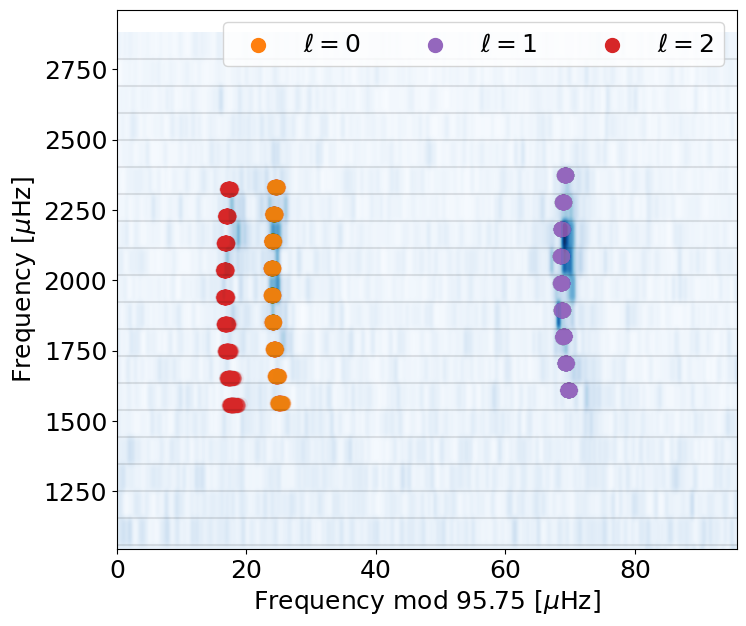

In [10]:
M.echelle();

## 2. Detailed peakbagging
The detailed peakbagging stage is meant to remove the constraints from the various models we use to define the frequency pattern in the mode ID stage. 

It's possible to run the peakbag stage without doing the mode ID stage first, so that you can supply your own solutions if the mode ID is wonky. It's even possible to run it with just the angular degree and frequencies as inputs, but performs a lot better if you pass it the mode heights and widths too.

**Note:** You may want to use the full resolution spectrum for the detailed peakbagging. It will take longer but should give you the highest precision on your frequencies.

In [31]:
from pbjam.peakbagging import peakbag

result = M.result

pb = peakbag(f, s, 
             ell=result['ell'], 
             freq=result['summary']['freq'], 
             height=result['summary']['height'], 
             width=result['summary']['width'], 
             slices=7)

Creating envelope slices


100%|█████████████████████████████████████████████| 9/9 [00:18<00:00,  2.07s/it]


Notice the `slices` argument. By default PBjam will try to divide the spectrum into sections to fit independently. Doing what is sometimes called a global peakbagging run, i.e., where all the modes in the envelope are fit at the same time, can be computationally expensive. In some cases it might take several hours to do the detailed peakbagging on a single star. Nested sampling is significantly faster for smaller parameter spaces though, so things get a lot faster if we consider just a few modes at a time. PBjam will therefore try to divide the spectrum into `slices` sections and fit them independently. It will try to divide along the radial orders but will avoid splitting l=2,0 mode pairs and other close separations, so you may not wind up with exactly the number of slices you requested.

**Note** If you have the time and CPU power, and want the best precision, then you should set Nslices=0 and let PBjam fit everything. This can take a loooong time though. This is particularly relevant for measuring inclination and the core/envelope rotation rates.

We can now simply call the `pb` class instance to run the sampling.

In [34]:
result = pb()

Peakbagging envelope slices


100%|█████████████████████████████████████████████| 9/9 [03:27<00:00, 23.10s/it]


(<Figure size 1600x900 with 1 Axes>,
 <Axes: xlabel='Frequency ($\\mu \\rm Hz$)', ylabel='PSD [$\\mathrm{ppm}^2/\\mu \\rm Hz$]'>)

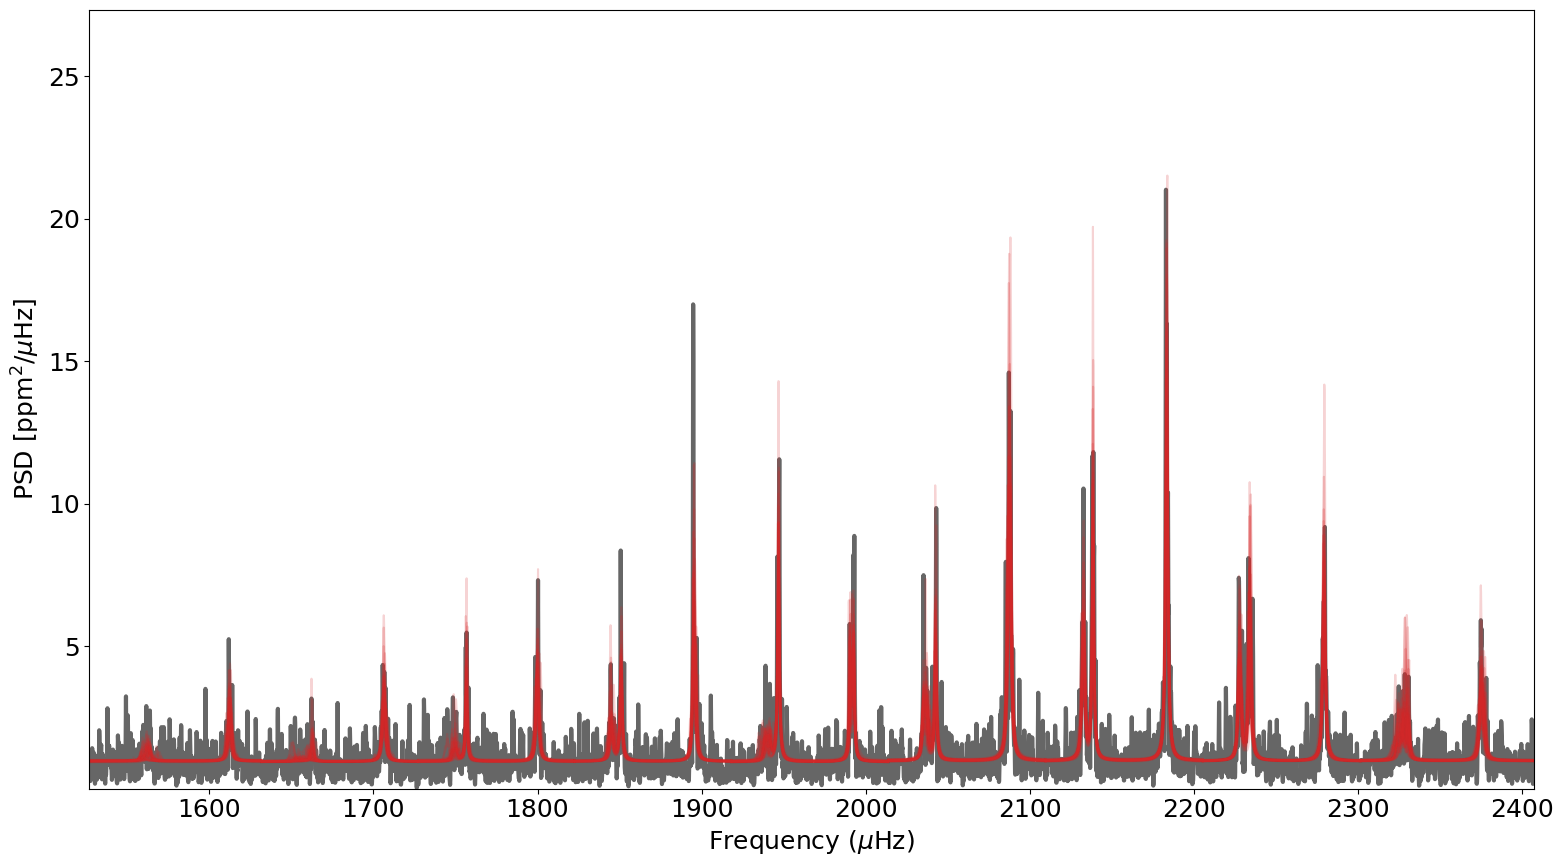

In [37]:
pb.spectrum()

One downside to using the slicing technique to fit the modes is that properties like inclination and rotation, which are in principle shared amongst all the modes, must be fit independently for each slice. We therefore include an option to compute the joint probability of the posterior distributions for the inclination and rotation parameters of all the slices. 

This is not the optimal way of measuring these parameters however, so if you care about them, it is best to avoid using the slicing method. The entire envelope should be fit at the same time.

In [38]:
from pbjam.peakbagging import jointRotInc

J = jointRotInc(pb)

result = J()

100%|█████████████████████████████████████████| 500/500 [07:58<00:00,  1.04it/s]


## 3. Plotting the results

PBjam has some built in methods for plotting the results. These are the same if called from the mode ID or peakbag class, and most contain an option to plot either models drawn from the prior or posterior.

The methods are:
- `spectrum`: plots the spectrum of the model. For the mode ID stage this will show both the full spectrum, a zoom on the envelope and various residual plots.
- `echelle`: creates an echelle diagram. 
- `corner`: creates a corner plot of the samples. Selecting unpacked=True, will transform the results to linear scale etc. 
- `reference`: plot the result of the mode ID in relation to the prior that was drawn. This is useful for diagnosing problems with the mode ID.

**Note** Some of these plotting functions (particularly corner) can take a while to show, and take a fair amount of memory, so take care with them.

If you prefer to plot the models on your own, you can draw samples and then plot the resulting models by doing the following:

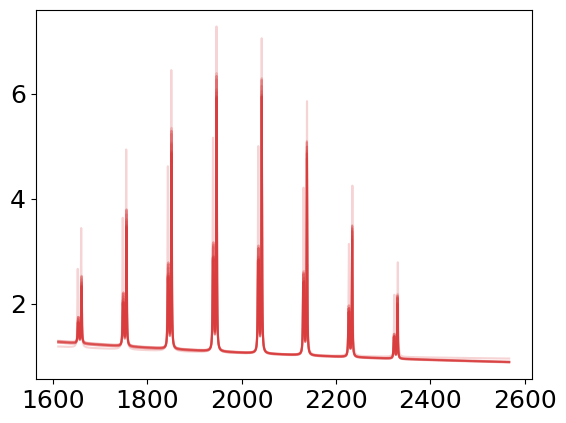

In [42]:
Nsamples = 10

module = M.l20model #replace this with M.l1model or pb.pbInstances[slice]

fig, ax = plt.subplots()
for k in range(Nsamples):
    
    sample = module.samples[k, :]

    unpacked = module.unpackParams(sample)

    mod = module.model(unpacked)

    ax.plot(module.f, mod, alpha=0.2, color='C3')

## 4. Specifying manual prior probability densities in the mode ID stage
In the event that your target is in a part of parameter space that is poorly sampled it may sometimes be necessary to provide a prior manually for the mode ID to work.

In PBjam 2.0 this is done by supplying a distribution class instance from the `pbjam.distributions` module. These function more or less the same as the corresponding `scipy.stats` versions, with the important distinction that they can be incorporated into a function that is jit-compiled with Jax. Jax is a accelerated linear algebra library that can compile individual functions. Jax is continually being developed, so these functions may become redundant in the future. 

An example could be if we are reasonably certain about the p-mode phase offset $\epsilon_p$, for a star, and so don't want PBjam to define a prior on its own.

In [25]:
import pbjam.distributions as dist

addPriors = {'eps_p': dist.normal(loc=1.45, scale=0.1)}

M_manual = modeID(f, s, addObs, N_p=N_p, addPriors=addPriors)

Before running the sampling it is often useful to do what is known as a prior predictive check. Here samples are drawn from the prior distribution and the model is evaluated. You can then check that the prior you have chosen makes sense. Most of the plotting functions in PBjam will have an option to do this.

In [ ]:
M_manual.spectrum(stage='prior')

If this looks vaguely sensible you can try running it.

In [29]:
M_manual.runl20model();

22286it [03:59, 93.07it/s, +650 | bound: 216 | nc: 1 | ncall: 681455 | eff(%):  3.369 | loglstar:   -inf < -8543.069 <    inf | logz: -8577.154 +/-  0.252 | dlogz:  0.001 >  0.659]


(<Figure size 800x700 with 1 Axes>,
 array([<Axes: xlabel='Frequency mod 95.66 [$\\mu$Hz]', ylabel='Frequency [$\\mu$Hz]'>],
       dtype=object))

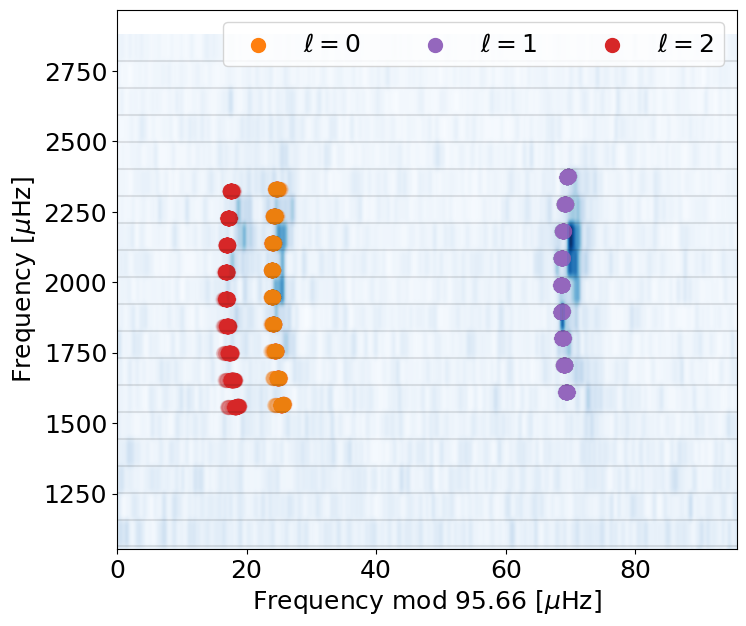

In [30]:
M.echelle()

You should be careful though since many parameters, like $\nu_{\mathrm{max}}$ or $\Delta \nu$, need to be specified in terms of their logarithms. You can check the list of model parameters for the l20 model class by inspecting the variables attribute. Unfortunately this is currently only accessible once the model class has been initialized, this will probably be changed in future updates.

In [28]:
M.l20model.variables

{'dnu': {'info': 'large frequency separation',
  'log10': True,
  'pca': True,
  'unit': 'muHz'},
 'numax': {'info': 'frequency at maximum power',
  'log10': True,
  'pca': True,
  'unit': 'muHz'},
 'eps_p': {'info': 'phase offset of the p-modes',
  'log10': False,
  'pca': True,
  'unit': 'None'},
 'd02': {'info': 'l=0,2 mean frequency difference',
  'log10': True,
  'pca': True,
  'unit': 'muHz'},
 'alpha_p': {'info': 'curvature of the p-modes',
  'log10': True,
  'pca': True,
  'unit': 'None'},
 'env_width': {'info': 'envelope width',
  'log10': True,
  'pca': True,
  'unit': 'muHz'},
 'env_height': {'info': 'envelope height',
  'log10': True,
  'pca': True,
  'unit': 'ppm^2/muHz'},
 'mode_width': {'info': 'mode width',
  'log10': True,
  'pca': True,
  'unit': 'muHz'},
 'teff': {'info': 'effective temperature',
  'log10': True,
  'pca': True,
  'unit': 'K'},
 'bp_rp': {'info': 'Gaia Gbp-Grp color',
  'log10': False,
  'pca': True,
  'unit': 'mag'},
 'H1_nu': {'info': 'Frequency of 